In [2]:
from __future__ import annotations

import json
from pathlib import Path
from typing import Any, Dict, Iterable, List

import pandas as pd

from mainnet_launch.constants import WORKING_DATA_DIR, AutopoolConstants
from mainnet_launch.database.postgres_operations import (
    get_full_table_as_df_with_block,
    get_full_table_as_df,
    get_full_table_as_df_with_tx_hash,
)
from mainnet_launch.database.schema.full import (
    DestinationStates,
    Destinations,
    AutopoolDestinations,
    RebalanceEvents,
    RebalancePlans,
    Blocks,
)


from mainnet_launch.constants import AUTO_ETH, BASE_ETH

import plotly.express as px
import plotly.io as pio
import numpy as np
import plotly.express as px
import plotly.io as pio


pio.templates.default = "plotly_white"


def _flatten_json(obj: Any, prefix: str = "", sep: str = ".") -> Dict[str, Any]:
    """
    Recursively flatten dict/list JSON into a single-level dict.

    - dict keys become: prefix.key
    - list items become: prefix[0], prefix[1], ...
    """
    out: Dict[str, Any] = {}

    if isinstance(obj, dict):
        for k, v in obj.items():
            key = f"{prefix}{sep}{k}" if prefix else str(k)
            out.update(_flatten_json(v, key, sep=sep))
        return out

    if isinstance(obj, list):
        for i, v in enumerate(obj):
            key = f"{prefix}[{i}]"
            out.update(_flatten_json(v, key, sep=sep))
        return out

    # primitives (str/int/float/bool/None)
    out[prefix] = obj
    return out


def load_augmented_plans_as_df(
    autopool: AutopoolConstants,
    *,
    save_root: Path = WORKING_DATA_DIR,
    glob_pattern: str = "*.json",
    flatten_sep: str = ".",
) -> pd.DataFrame:
    """
    Reads all augmented plan JSONs for an autopool from:
      WORKING_DATA_DIR / f"{autopool.name}_augmented_plans"

    Returns a DataFrame with:
      - one row per plan
      - ALL values, flattened (including destinationIn/Out, destinationOutSummaryStats, start_vp/end_vp, etc.)
      - a couple convenience columns for file path + json key
    """
    plans_dir = save_root / f"{autopool.name}_augmented_plans"
    if not plans_dir.exists():
        raise FileNotFoundError(f"Augmented plans dir not found: {plans_dir}")

    rows: List[Dict[str, Any]] = []
    json_paths = sorted(plans_dir.glob(glob_pattern))

    for p in json_paths:
        with open(p, "r") as f:
            plan = json.load(f)

        for k in ["sod", "steps", "addRank", "rebalanceTest"]:
            # don't care about these for now, and they add a lot of noise to the flattened keys
            plan.pop(k, None)
        flat = _flatten_json(plan, sep=flatten_sep)

        # a couple helpful traceability fields
        flat["file_path"] = str(p)
        rows.append(flat)

    df = pd.DataFrame(rows)

    df["predicted_fee_and_base_out"] = (
        df["destinationOutSummaryStats.out.feeApr"] + df["destinationOutSummaryStats.out.baseApr"]
    ) * 100

    df["predicted_fee_and_base_in"] = (
        df["destinationOutSummaryStats.in.feeApr"] + df["destinationOutSummaryStats.in.baseApr"]
    ) * 100

    df["actual_fee_and_base_out"] = df["out_fee_and_base"]
    df["actual_fee_and_base_in"] = df["in_fee_and_base"]

    destinations_to_name = {
        d.destination_vault_address: d.name for d in get_full_table_as_df(Destinations).itertuples()
    }
    df["out_name"] = df["destinationOut"].map(destinations_to_name)
    df["in_name"] = df["destinationIn"].map(destinations_to_name)

    df["datetime"] = pd.to_datetime(df["timestamp"], unit="s")
    print(df.columns)
    interesting_cols = [
        "datetime",
        "out_name",
        "in_name",
        "predicted_fee_and_base_out",
        "predicted_fee_and_base_in",
        "actual_fee_and_base_out",
        "actual_fee_and_base_in",
        "destinationOut",
        "destinationIn",
        "autopool_vault_address",
        "start_vp.out virtual_price",
        "start_vp.in virtual_price",
        "end_vp.out virtual_price",
        "end_vp.in virtual_price",
        "block_30_days_in_future",
        "file_path",
        "timestamp_30_days_in_future",
        "destinationOutSummaryStats.out.baseApr",
        "destinationOutSummaryStats.out.feeApr",
        "destinationOutSummaryStats.out.incentiveApr",
        "destinationOutSummaryStats.in.baseApr",
        "destinationOutSummaryStats.in.feeApr",
        "destinationOutSummaryStats.in.incentiveApr",
    ]
    return df[interesting_cols]


def add_diagonal_line(fig, start=0, end=12):
    """Add a diagonal x=y reference line to a plotly figure"""
    fig.add_shape(
        type="line",
        x0=start,
        y0=start,
        x1=end,
        y1=end,
        line=dict(dash="dash", color="gray", width=2),
    )
    return fig


def add_estimation_labels(fig, start=0, end=12, band=0.5):
    """Add 'Overestimated'/'Underestimated' labels + +/- band lines (y=x±band)."""
    fig.add_annotation(
        x=0.95,
        y=0.05,
        xref="paper",
        yref="paper",
        text="Overestimated",
        showarrow=False,
        font=dict(size=14, color="black"),
        align="right",
    )
    fig.add_annotation(
        x=0.05,
        y=0.95,
        xref="paper",
        yref="paper",
        text="Underestimated",
        showarrow=False,
        font=dict(size=14, color="black"),
        align="left",
    )

    # y = x + band
    fig.add_shape(
        type="line",
        x0=start,
        y0=start + band,
        x1=end,
        y1=end + band,
        line=dict(dash="dot", color="black", width=1),
    )
    # y = x - band
    fig.add_shape(
        type="line",
        x0=start + band,
        y0=start,
        x1=end + band,
        y1=end,
        line=dict(dash="dot", color="black", width=1),
    )
    return fig


def add_helpers(fig, start=0, end=12, band=0.5):
    fig = add_diagonal_line(fig, start=start, end=end)
    fig = add_estimation_labels(fig, start=start, end=end, band=band)
    return fig


def _scatter_pred_vs_actual(
    df,
    *,
    pred_col: str,
    actual_col: str,
    title: str,
    hover_cols: list[str],
    label_col: str | None = None,
):
    d = df.copy()
    d = d[np.isfinite(d[pred_col]) & np.isfinite(d[actual_col])]

    if len(d) == 0:
        print(f"{title}: no data after filters")
        return None

    # choose axis range based on filtered data (robust-ish)
    lo = float(min(d[pred_col].min(), d[actual_col].min()))
    hi = float(max(d[pred_col].max(), d[actual_col].max()))

    # if APR is percent-like and you want to clamp to something sane, do it here
    # (otherwise it'll just use your data range)
    pad = 0.05 * (hi - lo) if hi > lo else 1.0
    start = max(0.0, lo - pad)  # keep at >=0 since we're excluding negative actual
    end = hi + pad

    fig = px.scatter(
        d,
        x=pred_col,
        y=actual_col,
        color=label_col if label_col and (label_col in d.columns) else None,
        hover_data=hover_cols,
        title=title,
    )
    fig.update_xaxes(range=[start, end])
    fig.update_yaxes(range=[start, end])
    fig = add_helpers(fig, start=start, end=end, band=1.0)
    fig.show()


# Example usage:


def create_combined_df(df):
    """Combine in and out predictions into a single dataframe with errors."""
    in_df = (
        df[["datetime", "in_name", "predicted_fee_and_base_in", "actual_fee_and_base_in", "file_path"]]
        .copy()
        .rename(
            columns={
                "predicted_fee_and_base_in": "predicted",
                "actual_fee_and_base_in": "actual",
                "in_name": "name",
            }
        )
    )

    out_df = (
        df[["datetime", "out_name", "predicted_fee_and_base_out", "actual_fee_and_base_out", "file_path"]]
        .copy()
        .rename(
            columns={
                "predicted_fee_and_base_out": "predicted",
                "actual_fee_and_base_out": "actual",
                "out_name": "name",
            }
        )
    )

    combined_df = pd.concat([in_df, out_df], ignore_index=True)
    combined_df["error"] = combined_df["predicted"] - combined_df["actual"]
    return combined_df.sort_values("error")


df = load_augmented_plans_as_df(AUTO_ETH)
autoETH_combined = create_combined_df(df)
base_df = load_augmented_plans_as_df(BASE_ETH)
baseeth_combined = create_combined_df(base_df)

Index(['timestamp', 'sodOnly', 'chainId', 'solverAddress', 'poolAddress',
       'destinationOut', 'tokenOut', 'amountOut', 'amountOutETH',
       'destinationIn', 'tokenIn', 'minAmountIn', 'minAmountInETH',
       'rebalance_plan_json_key', 'autopool_vault_address',
       'destinationOutSummaryStats.out.destination',
       'destinationOutSummaryStats.out.baseApr',
       'destinationOutSummaryStats.out.feeApr',
       'destinationOutSummaryStats.out.incentiveApr',
       'destinationOutSummaryStats.out.safeTotalSupply',
       'destinationOutSummaryStats.out.priceReturn',
       'destinationOutSummaryStats.out.maxDiscount',
       'destinationOutSummaryStats.out.maxPremium',
       'destinationOutSummaryStats.out.ownedShares',
       'destinationOutSummaryStats.out.compositeReturn',
       'destinationOutSummaryStats.out.pricePerShare',
       'destinationOutSummaryStats.in.destination',
       'destinationOutSummaryStats.in.baseApr',
       'destinationOutSummaryStats.in.feeApr',
 

In [7]:
suspect_overestimated_fee_and_base = "Tokemak-Wrapped Ether-Volatile AMM - weETH.base/WETH"
suspect_df = base_df[
    (base_df["out_name"] == suspect_overestimated_fee_and_base)
    | (base_df["in_name"] == suspect_overestimated_fee_and_base)
]
suspect_df

,datetime,out_name,in_name,predicted_fee_and_base_out,predicted_fee_and_base_in,actual_fee_and_base_out,actual_fee_and_base_in,destinationOut,destinationIn,autopool_vault_address,...,end_vp.in virtual_price,block_30_days_in_future,file_path,timestamp_30_days_in_future,destinationOutSummaryStats.out.baseApr,destinationOutSummaryStats.out.feeApr,destinationOutSummaryStats.out.incentiveApr,destinationOutSummaryStats.in.baseApr,destinationOutSummaryStats.in.feeApr,destinationOutSummaryStats.in.incentiveApr
1,2024-11-08 21:38:50,baseETH,Tokemak-Wrapped Ether-Volatile AMM - weETH.bas...,0.000000,1.351216,0.0,-55.342397,0xAADf01DD90aE0A6Bb9Eb908294658037096E0404,0x945a4f719018edBa445ca67bDa43663C815835Ad,0xAADf01DD90aE0A6Bb9Eb908294658037096E0404,...,2.104809e+21,23452307,/Users/pb/Documents/Github/Tokemak/v2-rebalanc...,1733693961,0.000000,0.000000,0.0,0.013512,0.0,0.059472
2,2024-11-09 12:22:56,baseETH,Tokemak-Wrapped Ether-Volatile AMM - weETH.bas...,0.000000,1.362240,0.0,-55.521894,0xAADf01DD90aE0A6Bb9Eb908294658037096E0404,0x945a4f719018edBa445ca67bDa43663C815835Ad,0xAADf01DD90aE0A6Bb9Eb908294658037096E0404,...,2.114577e+21,23478830,/Users/pb/Documents/Github/Tokemak/v2-rebalanc...,1733747007,0.000000,0.000000,0.0,0.013622,0.0,0.059896
3,2024-11-09 22:47:46,baseETH,Tokemak-Wrapped Ether-Volatile AMM - weETH.bas...,0.000000,1.362408,0.0,-55.729732,0xAADf01DD90aE0A6Bb9Eb908294658037096E0404,0x945a4f719018edBa445ca67bDa43663C815835Ad,0xAADf01DD90aE0A6Bb9Eb908294658037096E0404,...,2.115521e+21,23497577,/Users/pb/Documents/Github/Tokemak/v2-rebalanc...,1733784501,0.000000,0.000000,0.0,0.013624,0.0,0.059984
4,2024-11-12 04:47:46,baseETH,Tokemak-Wrapped Ether-Volatile AMM - weETH.bas...,0.000000,1.368438,0.0,-79.701052,0xAADf01DD90aE0A6Bb9Eb908294658037096E0404,0x945a4f719018edBa445ca67bDa43663C815835Ad,0xAADf01DD90aE0A6Bb9Eb908294658037096E0404,...,1.990193e+21,23594775,/Users/pb/Documents/Github/Tokemak/v2-rebalanc...,1733978897,0.000000,0.000000,0.0,0.013684,0.0,0.057609
5,2024-11-13 16:18:21,baseETH,Tokemak-Wrapped Ether-Volatile AMM - weETH.bas...,0.000000,1.368502,0.0,26.658016,0xAADf01DD90aE0A6Bb9Eb908294658037096E0404,0x945a4f719018edBa445ca67bDa43663C815835Ad,0xAADf01DD90aE0A6Bb9Eb908294658037096E0404,...,2.077832e+21,23658695,/Users/pb/Documents/Github/Tokemak/v2-rebalanc...,1734106737,0.000000,0.000000,0.0,0.013685,0.0,0.060770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252,2025-09-05 04:02:06,Tokemak-Wrapped Ether-Gyroscope ECLP cbETH/wstETH,Tokemak-Wrapped Ether-Volatile AMM - weETH.bas...,3.146653,1.296773,NaN,653.416439,0xBd137c56f3116E5c36753037a784FF844F84F59c,0x945a4f719018edBa445ca67bDa43663C815835Ad,0xAADf01DD90aE0A6Bb9Eb908294658037096E0404,...,5.728128e+20,36423822,/Users/pb/Documents/Github/Tokemak/v2-rebalanc...,1759636991,0.013284,0.018183,0.0,0.012968,0.0,0.042825
253,2025-09-13 04:02:07,baseETH,Tokemak-Wrapped Ether-Volatile AMM - weETH.bas...,0.000000,1.280348,0.0,-86.048437,0xAADf01DD90aE0A6Bb9Eb908294658037096E0404,0x945a4f719018edBa445ca67bDa43663C815835Ad,0xAADf01DD90aE0A6Bb9Eb908294658037096E0404,...,5.673168e+20,36769410,/Users/pb/Documents/Github/Tokemak/v2-rebalanc...,1760328167,0.000000,0.000000,0.0,0.012803,0.0,0.029473
256,2025-09-19 10:02:06,baseETH,Tokemak-Wrapped Ether-Volatile AMM - weETH.bas...,0.000000,1.281565,0.0,-86.551406,0xAADf01DD90aE0A6Bb9Eb908294658037096E0404,0x945a4f719018edBa445ca67bDa43663C815835Ad,0xAADf01DD90aE0A6Bb9Eb908294658037096E0404,...,5.602466e+20,37039411,/Users/pb/Documents/Github/Tokemak/v2-rebalanc...,1760868169,0.000000,0.000000,0.0,0.012816,0.0,0.030052
257,2025-09-20 22:02:06,baseETH,Tokemak-Wrapped Ether-Volatile AMM - weETH.bas...,0.000000,1.285883,0.0,-87.339738,0xAADf01DD90aE0A6Bb9Eb908294658037096E0404,0x945a4f719018edBa445ca67bDa43663C815835Ad,0xAADf01DD90aE0A6Bb9Eb908294658037096E0404,...,5.608103e+20,37104212,/Users/pb/Documents/Github/Tokemak/v2-rebalanc...,1760997771,0.000000,0.000000,0.0,0.012859,0.0,0.03002

In [ ]:
from datetime import datetime, timedelta


_scatter_pred_vs_actual(
    autoETH_combined,
    pred_col="predicted",
    actual_col="actual",
    title="AUTO-ETH: Predicted vs Actual Fee+Base APR (Combined In/Out, All Data)",
    hover_cols=["datetime"],
    label_col="name",
)

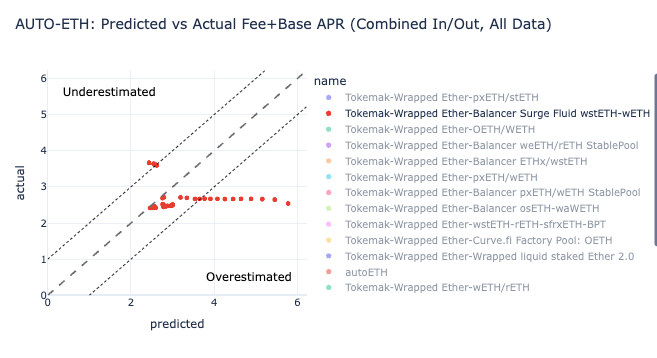

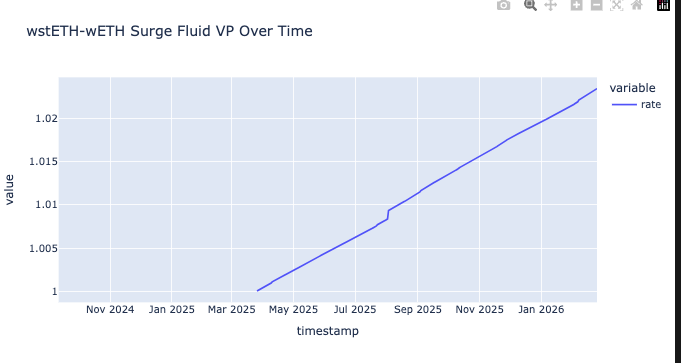 this is in august

In [ ]:
from datetime import datetime, timedelta

# Filter to last 6 months
six_months_ago = datetime.now() - timedelta(days=180 + 90)
recent_data = autoETH_combined[autoETH_combined["datetime"] >= six_months_ago]

_scatter_pred_vs_actual(
    recent_data,
    pred_col="predicted",
    actual_col="actual",
    title="AUTO-ETH: Predicted vs Actual Fee+Base APR (Combined In/Out, Last 6 Months)",
    hover_cols=["datetime"],
    label_col="name",
)

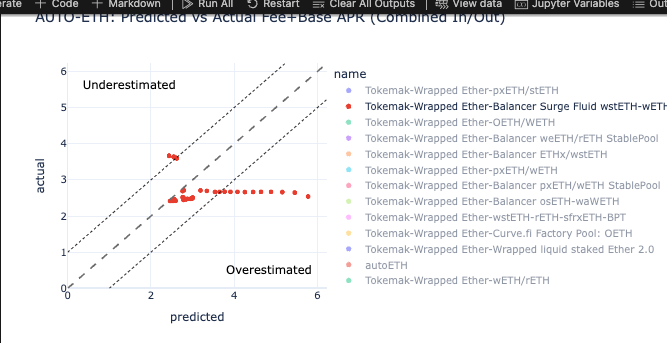


surge fuild is weird here 


In [12]:
# Exclude the suspect pool
baseeth_filtered = baseeth_combined[baseeth_combined["name"] != suspect_overestimated_fee_and_base]

_scatter_pred_vs_actual(
    baseeth_filtered,
    pred_col="predicted",
    actual_col="actual",
    title="BASE-ETH: Predicted vs Actual Fee+Base APR (Combined In/Out, weETH.base/WETH excluded)",
    hover_cols=["datetime"],
    label_col="name",
)

In [ ]:
# baseETH_combined = create_combined_df(df_base_eth)
# # Tokemak-Wrapped Ether-Volatile AMM - weETH.base/WETH known bad data
# baseETH_combined

In [8]:
insta_dapp_df = autoETH_combined[autoETH_combined["name"] == "Tokemak-Wrapped Ether-Instadapp ETH v2"]
_scatter_pred_vs_actual(
    insta_dapp_df,
    title="Predicted vs Actual Fee+Base APR for Instadapp ETH v2",
)

TypeError: _scatter_pred_vs_actual() missing 3 required keyword-only arguments: 'pred_col', 'actual_col', and 'hover_cols'

In [ ]:
base_ETH_known_incorrect = "Tokemak-Wrapped Ether-Volatile AMM - weETH.base/WETH"  # actual is wrong
autoETH_predicted_is_wrong = [
    "Tokemak-Wrapped Ether-pxETH/stETH",
    "Tokemak-Wrapped Ether-pxETH/wETH",
]  # predicted is zero here when it shouldn't

overestimated = (
    "Tokemak-Wrapped Ether-Curve.fi Factory Pool: ETHx-ETH",
    "Tokemak-Wrapped Ether-osETH/rETH",
    "Tokemak-Wrapped Ether-Curve.fi Factory Pool: ETHx-ETH",
)

In [ ]:
df

,datetime,out_name,in_name,predicted_fee_and_base_out,predicted_fee_and_base_in,actual_fee_and_base_out,actual_fee_and_base_in,destinationOut,destinationIn,autopool_vault_address,start_vp.out virtual_price,start_vp.in virtual_price,end_vp.out virtual_price,end_vp.in virtual_price,block_30_days_in_future,_file_path
0,2024-09-17 19:40:27,autoETH,Tokemak-Wrapped Ether-pxETH/wETH,0.000000,0.130418,0.000000,0.097852,0x0A2b94F6871c1D7A32Fe58E1ab5e6deA2f114E56,0xE382BBd32C4E202185762eA433278f4ED9E6151E,0x0A2b94F6871c1D7A32Fe58E1ab5e6deA2f114E56,1.000000,1.000724,1.000000,1.000805,20987444,/Users/pb/Documents/Github/Tokemak/v2-rebalanc...
1,2024-09-18 04:00:22,autoETH,Tokemak-Wrapped Ether-pxETH/wETH,0.000000,0.130418,0.000000,0.102879,0x0A2b94F6871c1D7A32Fe58E1ab5e6deA2f114E56,0xE382BBd32C4E202185762eA433278f4ED9E6151E,0x0A2b94F6871c1D7A32Fe58E1ab5e6deA2f114E56,1.000000,1.000724,1.000000,1.000809,20989931,/Users/pb/Documents/Github/Tokemak/v2-rebalanc...
2,2024-09-18 16:20:59,autoETH,Tokemak-Wrapped Ether-pxETH/stETH,0.000000,1.509600,0.000000,1.396379,0x0A2b94F6871c1D7A32Fe58E1ab5e6deA2f114E56,0xd96E943098B2AE81155e98D7DC8BeaB34C539f01,0x0A2b94F6871c1D7A32Fe58E1ab5e6deA2f114E56,1.000000,1.009840,1.000000,1.010991,20993614,/Users/pb/Documents/Github/Tokemak/v2-rebalanc...
3,2024-09-19 02:56:00,autoETH,Tokemak-Wrapped Ether-pxETH/stETH,0.000000,1.510501,0.000000,1.396356,0x0A2b94F6871c1D7A32Fe58E1ab5e6deA2f114E56,0xd96E943098B2AE81155e98D7DC8BeaB34C539f01,0x0A2b94F6871c1D7A32Fe58E1ab5e6deA2f114E56,1.000000,1.009840,1.000000,1.010991,20996777,/Users/pb/Documents/Github/Tokemak/v2-rebalanc...
4,2024-09-19 13:24:21,autoETH,Tokemak-Wrapped Ether-pxETH/wETH,0.000000,0.107579,0.000000,0.102343,0x0A2b94F6871c1D7A32Fe58E1ab5e6deA2f114E56,0xE382BBd32C4E202185762eA433278f4ED9E6151E,0x0A2b94F6871c1D7A32Fe58E1ab5e6deA2f114E56,1.000000,1.000725,1.000000,1.000809,20999903,/Users/pb/Documents/Github/Tokemak/v2-rebalanc...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
637,2026-01-10 22:29:56,Tokemak-Wrapped Ether-pxETH/wETH,Tokemak-Wrapped Ether-Instadapp ETH v2,0.339333,5.120312,0.663205,3.995175,0x43D99d04985ef2231f7d9b5D9111D2189d9FD971,0x2C7120dCCF1c14A37A26A4955475d45d34a3d7E7,0x0A2b94F6871c1D7A32Fe58E1ab5e6deA2f114E56,1.003794,1.197783,1.004339,1.201646,24422209,/Users/pb/Documents/Github/Tokemak/v2-rebalanc...
638,2026-01-12 12:29:56,Tokemak-Wrapped Ether-pxETH/wETH,Tokemak-Wrapped Ether-Instadapp ETH v2,0.450756,4.976122,0.815797,3.730939,0x43D99d04985ef2231f7d9b5D9111D2189d9FD971,0x2C7120dCCF1c14A37A26A4955475d45d34a3d7E7,0x0A2b94F6871c1D7A32Fe58E1ab5e6deA2f114E56,1.003822,1.198033,1.004492,1.201646,24433544,/Users/pb/Documents/Github/Tokemak/v2-rebalanc...
639,2026-01-12 22:29:56,Tokemak-Wrapped Ether-pxETH/wETH,Tokemak-Wrapped Ether-Instadapp ETH v2,0.450756,4.976122,0.825424,3.730939,0x43D99d04985ef2231f7d9b5D9111D2189d9FD971,0x2C7120dCCF1c14A37A26A4955475d45d34a3d7E7,0x0A2b94F6871c1D7A32Fe58E1ab5e6deA2f114E56,1.003847,1.198033,1.004525,1.201646,24436529,/Users/pb/Documents/Github/Tokemak/v2-rebalanc...
640,2026-01-13 14:29:56,Tokemak-Wrapped Ether-pxETH/wETH,Tokemak-Wrapped Ether-Instadapp ETH v2,0.563539,4.976122,0.811259,3.611731,0x43D99d04985ef2231f7d9b5D9111D2189d9FD971,0x2C7120dCCF1c14A37A26A4955475d45d34a3d7E7,0x0A2b94F6871c1D7A32Fe58E1ab5e6deA2f114E56,1.003863,1.198147,1.004530,1.201646,24441308,/Users/pb/Documents/Github/Tokemak/v2-rebalanc...


In [ ]:
autoETH_combined

,datetime,name,predicted,actual,error
1137,2025-06-27 09:45:45,Tokemak-Wrapped Ether-pxETH/stETH,0.000000,1.454260,-1.454260
1136,2025-06-27 00:45:44,Tokemak-Wrapped Ether-pxETH/stETH,0.000000,1.438685,-1.438685
1135,2025-06-26 14:45:45,Tokemak-Wrapped Ether-pxETH/stETH,0.000000,1.437574,-1.437574
1133,2025-06-25 13:01:50,Tokemak-Wrapped Ether-pxETH/stETH,0.000000,1.433173,-1.433173
1134,2025-06-26 05:45:44,Tokemak-Wrapped Ether-pxETH/stETH,0.000000,1.431075,-1.431075
...,...,...,...,...,...
621,2025-10-05 12:56:00,Tokemak-Wrapped Ether-wstETH-rETH-sfrxETH-BPT,1.685594,NaN,NaN
622,2025-10-09 14:56:00,Tokemak-Wrapped Ether-wstETH-rETH-sfrxETH-BPT,1.650282,NaN,NaN
623,2025-10-10 14:56:00,Tokemak-Wrapped Ether-wstETH-rETH-sfrxETH-BPT,1.646946,NaN,NaN
626,2025-10-16 16:56:00,Tokemak-Wrapped Ether-wstETH-rETH-sfrxETH-BPT,1.613960,NaN,NaN


In [ ]:
autoETH_combined

,datetime,name,predicted,actual,error
0,2024-09-17 19:40:27,Tokemak-Wrapped Ether-pxETH/wETH,0.130418,0.097852,0.032566
1,2024-09-18 04:00:22,Tokemak-Wrapped Ether-pxETH/wETH,0.130418,0.102879,0.027539
2,2024-09-18 16:20:59,Tokemak-Wrapped Ether-pxETH/stETH,1.509600,1.396379,0.113221
3,2024-09-19 02:56:00,Tokemak-Wrapped Ether-pxETH/stETH,1.510501,1.396356,0.114145
4,2024-09-19 13:24:21,Tokemak-Wrapped Ether-pxETH/wETH,0.107579,0.102343,0.005236
...,...,...,...,...,...
1279,2026-01-10 22:29:56,Tokemak-Wrapped Ether-pxETH/wETH,0.339333,0.663205,-0.323872
1280,2026-01-12 12:29:56,Tokemak-Wrapped Ether-pxETH/wETH,0.450756,0.815797,-0.365041
1281,2026-01-12 22:29:56,Tokemak-Wrapped Ether-pxETH/wETH,0.450756,0.825424,-0.374667
1282,2026-01-13 14:29:56,Tokemak-Wrapped Ether-pxETH/wETH,0.563539,0.811259,-0.247720


,datetime,out_name,in_name,predicted_fee_and_base_out,predicted_fee_and_base_in,actual_fee_and_base_out,actual_fee_and_base_in,destinationOut,destinationIn,autopool_vault_address,start_vp.out virtual_price,start_vp.in virtual_price,end_vp.out virtual_price,end_vp.in virtual_price,block_30_days_in_future,_file_path
491,2025-06-25 13:01:50,Tokemak-Wrapped Ether-pxETH/stETH,Tokemak-Wrapped Ether-Instadapp ETH v2,0.000000,2.786246,1.433173,0.837411,0xe4433D00Cf48BFE0C672d9949F2cd2c008bffC04,0x2C7120dCCF1c14A37A26A4955475d45d34a3d7E7,0x0A2b94F6871c1D7A32Fe58E1ab5e6deA2f114E56,1.019744,1.170068,1.020938,1.170871,22996341,/Users/pb/Documents/Github/Tokemak/v2-rebalanc...
496,2025-06-27 18:45:45,Tokemak-Wrapped Ether-Curve.fi Factory Pool: OETH,Tokemak-Wrapped Ether-Instadapp ETH v2,0.000000,2.884751,0.057349,0.702508,0x3772973f8F399D74488D5cF3276C032E0afC8A6f,0x2C7120dCCF1c14A37A26A4955475d45d34a3d7E7,0x0A2b94F6871c1D7A32Fe58E1ab5e6deA2f114E56,1.002264,1.170197,1.002311,1.170871,23012377,/Users/pb/Documents/Github/Tokemak/v2-rebalanc...
497,2025-06-28 03:45:45,Tokemak-Wrapped Ether-Curve.fi Factory Pool: OETH,Tokemak-Wrapped Ether-Instadapp ETH v2,0.000000,2.884751,0.058486,0.683576,0x3772973f8F399D74488D5cF3276C032E0afC8A6f,0x2C7120dCCF1c14A37A26A4955475d45d34a3d7E7,0x0A2b94F6871c1D7A32Fe58E1ab5e6deA2f114E56,1.002264,1.170215,1.002312,1.170871,23015060,/Users/pb/Documents/Github/Tokemak/v2-rebalanc...
498,2025-06-28 12:45:45,Tokemak-Wrapped Ether-Curve.fi Factory Pool: OETH,Tokemak-Wrapped Ether-Instadapp ETH v2,0.000000,2.884751,0.057013,0.477632,0x3772973f8F399D74488D5cF3276C032E0afC8A6f,0x2C7120dCCF1c14A37A26A4955475d45d34a3d7E7,0x0A2b94F6871c1D7A32Fe58E1ab5e6deA2f114E56,1.002266,1.170412,1.002313,1.170871,23017742,/Users/pb/Documents/Github/Tokemak/v2-rebalanc...
499,2025-06-28 21:45:45,Tokemak-Wrapped Ether-Curve.fi Factory Pool: OETH,Tokemak-Wrapped Ether-Instadapp ETH v2,0.000000,2.884751,0.057853,0.477632,0x3772973f8F399D74488D5cF3276C032E0afC8A6f,0x2C7120dCCF1c14A37A26A4955475d45d34a3d7E7,0x0A2b94F6871c1D7A32Fe58E1ab5e6deA2f114E56,1.002266,1.170412,1.002313,1.170871,23020420,/Users/pb/Documents/Github/Tokemak/v2-rebalanc...
500,2025-06-29 09:45:44,Tokemak-Wrapped Ether-Curve.fi Factory Pool: OETH,Tokemak-Wrapped Ether-Instadapp ETH v2,0.000000,2.884751,0.060687,0.477632,0x3772973f8F399D74488D5cF3276C032E0afC8A6f,0x2C7120dCCF1c14A37A26A4955475d45d34a3d7E7,0x0A2b94F6871c1D7A32Fe58E1ab5e6deA2f114E56,1.002266,1.170412,1.002316,1.170871,23023999,/Users/pb/Documents/Github/Tokemak/v2-rebalanc...
501,2025-06-29 18:45:45,Tokemak-Wrapped Ether-Curve.fi Factory Pool: OETH,Tokemak-Wrapped Ether-Instadapp ETH v2,0.000000,2.884751,0.062680,0.689706,0x3772973f8F399D74488D5cF3276C032E0afC8A6f,0x2C7120dCCF1c14A37A26A4955475d45d34a3d7E7,0x0A2b94F6871c1D7A32Fe58E1ab5e6deA2f114E56,1.002266,1.170412,1.002318,1.171073,23026678,/Users/pb/Documents/Github/Tokemak/v2-rebalanc...
502,2025-06-30 05:45:44,Tokemak-Wrapped Ether-Curve.fi Factory Pool: OETH,Tokemak-Wrapped Ether-Instadapp ETH v2,0.000000,2.819843,0.067041,0.689706,0x3772973f8F399D74488D5cF3276C032E0afC8A6f,0x2C7120dCCF1c14A37A26A4955475d45d34a3d7E7,0x0A2b94F6871c1D7A32Fe58E1ab5e6deA2f114E56,1.002266,1.170412,1.002322,1.171073,23029952,/Users/pb/Documents/Github/Tokemak/v2-rebalanc...
503,2025-07-04 06:45:44,Tokemak-Wrapped Ether-Balancer pxETH/wETH Stab...,Tokemak-Wrapped Ether-Instadapp ETH v2,0.237238,2.969015,0.241395,1.841439,0xc4Eb861e7b66f593482a3D7E8adc314f6eEDA30B,0x2C7120dCCF1c14A37A26A4955475d45d34a3d7E7,0x0A2b94F6871c1D7A32Fe58E1ab5e6deA2f114E56,1.003602,1.170827,1.003801,1.172584,23058847,/Users/pb/Documents/Github/Tokemak/v2-rebalanc...
504,2025-07-04 15:45:45,Tokemak-Wrapped Ether-Balancer pxETH/wETH Stab...,Tokemak-Wrapped Ether-Instadapp ETH v2,0.231433,2.969015,0.242372,1.593825,0xc4Eb861e7b66f593482a3D7E8adc314f6eEDA30B,0x2C7120dCCF1c14A37A26A4955475d45d34a3d7E7,0x0A2b94F6871c1D7A32Fe58E1ab5e6deA2f114E56,1.003603,1.171061,1.003803,1.172584,23061530,/Users/pb/Documents/

In [ ]:
# Calculate prediction errors
df_with_errors = df.copy()
df_with_errors["in_error"] = df_with_errors["predicted_fee_and_base_in"] - df_with_errors["actual_fee_and_base_in"]
df_with_errors["out_error"] = df_with_errors["predicted_fee_and_base_out"] - df_with_errors["actual_fee_and_base_out"]
df_with_errors["in_abs_error"] = df_with_errors["in_error"].abs()
df_with_errors["out_abs_error"] = df_with_errors["out_error"].abs()

# Filter out rows with missing values
df_valid = df_with_errors.dropna(subset=["in_error", "out_error"])

# Calculate statistics for outlier detection
in_error_mean = df_valid["in_error"].mean()
in_error_std = df_valid["in_error"].std()
out_error_mean = df_valid["out_error"].mean()
out_error_std = df_valid["out_error"].std()

print(f"IN Error Statistics: Mean={in_error_mean:.2f}, Std={in_error_std:.2f}")
print(f"OUT Error Statistics: Mean={out_error_mean:.2f}, Std={out_error_std:.2f}")
print("\n")

# Define outliers as those beyond 2 standard deviations
in_outliers = df_valid[df_valid["in_abs_error"] > (in_error_mean + 2 * in_error_std)]
out_outliers = df_valid[df_valid["out_abs_error"] > (out_error_mean + 2 * out_error_std)]

out_outliers

IN Error Statistics: Mean=0.64, Std=1.03
OUT Error Statistics: Mean=0.05, Std=0.60




,datetime,out_name,in_name,predicted_fee_and_base_out,predicted_fee_and_base_in,actual_fee_and_base_out,actual_fee_and_base_in,destinationOut,destinationIn,autopool_vault_address,start_vp.out virtual_price,start_vp.in virtual_price,end_vp.out virtual_price,end_vp.in virtual_price,block_30_days_in_future,_file_path,in_error,out_error,in_abs_error,out_abs_error
57,2024-10-16 19:30:21,Tokemak-Wrapped Ether-osETH/rETH,Tokemak-Wrapped Ether-Balancer pxETH/wETH Stab...,5.528564,0.029718,3.015806,0.078192,0x3F55eedDe51504E6Ed0ec30E8289b4Da11EdB7F9,0xc4Eb861e7b66f593482a3D7E8adc314f6eEDA30B,0x0A2b94F6871c1D7A32Fe58E1ab5e6deA2f114E56,1.027610,1.002514,1.030123,1.002578,21195204,/Users/pb/Documents/Github/Tokemak/v2-rebalanc...,-0.048474,2.512758,0.048474,2.512758
59,2024-10-17 13:30:21,Tokemak-Wrapped Ether-osETH/rETH,Tokemak-Wrapped Ether-Balancer pxETH/wETH Stab...,5.527812,0.029718,3.025193,0.078189,0x3F55eedDe51504E6Ed0ec30E8289b4Da11EdB7F9,0xc4Eb861e7b66f593482a3D7E8adc314f6eEDA30B,0x0A2b94F6871c1D7A32Fe58E1ab5e6deA2f114E56,1.027682,1.002514,1.030202,1.002578,21200586,/Users/pb/Documents/Github/Tokemak/v2-rebalanc...,-0.048471,2.502619,0.048471,2.502619
60,2024-10-17 22:30:21,Tokemak-Wrapped Ether-osETH/rETH,Tokemak-Wrapped Ether-Balancer pxETH/wETH Stab...,5.533620,0.026766,3.026323,0.078306,0x3F55eedDe51504E6Ed0ec30E8289b4Da11EdB7F9,0xc4Eb861e7b66f593482a3D7E8adc314f6eEDA30B,0x0A2b94F6871c1D7A32Fe58E1ab5e6deA2f114E56,1.027695,1.002514,1.030217,1.002578,21203271,/Users/pb/Documents/Github/Tokemak/v2-rebalanc...,-0.051540,2.507297,0.051540,2.507297
65,2024-10-20 10:30:21,Tokemak-Wrapped Ether-osETH/rETH,autoETH,5.513705,0.000000,3.068603,0.000000,0x3F55eedDe51504E6Ed0ec30E8289b4Da11EdB7F9,0x0A2b94F6871c1D7A32Fe58E1ab5e6deA2f114E56,0x0A2b94F6871c1D7A32Fe58E1ab5e6deA2f114E56,1.027901,1.000000,1.030457,1.000000,21221196,/Users/pb/Documents/Github/Tokemak/v2-rebalanc...,0.000000,2.445101,0.000000,2.445101
72,2024-10-23 22:30:21,Tokemak-Wrapped Ether-osETH/rETH,autoETH,5.448223,0.000000,3.104514,0.000000,0x3F55eedDe51504E6Ed0ec30E8289b4Da11EdB7F9,0x0A2b94F6871c1D7A32Fe58E1ab5e6deA2f114E56,0x0A2b94F6871c1D7A32Fe58E1ab5e6deA2f114E56,1.028141,1.000000,1.030727,1.000000,21246270,/Users/pb/Documents/Github/Tokemak/v2-rebalanc...,0.000000,2.343709,0.000000,2.343709
74,2024-10-24 10:30:21,Tokemak-Wrapped Ether-osETH/rETH,Tokemak-Wrapped Ether-Balancer pxETH/wETH Stab...,5.448198,0.045081,3.124917,0.080621,0x3F55eedDe51504E6Ed0ec30E8289b4Da11EdB7F9,0xc4Eb861e7b66f593482a3D7E8adc314f6eEDA30B,0x0A2b94F6871c1D7A32Fe58E1ab5e6deA2f114E56,1.028196,1.002524,1.030799,1.002590,21249864,/Users/pb/Documents/Github/Tokemak/v2-rebalanc...,-0.035539,2.323281,0.035539,2.323281
109,2024-11-21 07:30:21,Tokemak-Wrapped Ether-osETH/rETH,autoETH,5.819645,0.000000,2.925565,0.000000,0x3F55eedDe51504E6Ed0ec30E8289b4Da11EdB7F9,0x0A2b94F6871c1D7A32Fe58E1ab5e6deA2f114E56,0x0A2b94F6871c1D7A32Fe58E1ab5e6deA2f114E56,1.030613,1.000000,1.033059,1.000000,21449406,/Users/pb/Documents/Github/Tokemak/v2-rebalanc...,0.000000,2.894080,0.000000,2.894080
110,2024-11-21 10:30:21,Tokemak-Wrapped Ether-osETH/rETH,Tokemak-Wrapped Ether-pxETH/stETH,5.817051,1.051434,2.922130,1.102341,0x3F55eedDe51504E6Ed0ec30E8289b4Da11EdB7F9,0xe4433D00Cf48BFE0C672d9949F2cd2c008bffC04,0x0A2b94F6871c1D7A32Fe58E1ab5e6deA2f114E56,1.030618,1.012067,1.033061,1.012979,21450306,/Users/pb/Documents/Github/Tokemak/v2-rebalanc...,-0.050907,2.894921,0.050907,2.894921
112,2024-11-23 01:30:28,Tokemak-Wrapped Ether-osETH/rETH,Tokemak-Wrapped Ether-pxETH/stETH,5.796990,1.085434,2.886786,1.120117,0x3F55eedDe51504E6Ed0ec30E8289b4Da11EdB7F9,0xe4433D00Cf48BFE0C672d9949F2cd2c008bffC04,0x0A2b94F6871c1D7A32Fe58E1ab5e6deA2f114E56,1.030731,1.012123,1.033145,1.013050,21461929,/Users/pb/Documents/Github/Tokemak/v2-rebalanc...,-0.034683,2.910204,0.034683,2.910204
113,2024-11-23 22:30:21,Tokemak-Wrapped Ether-osETH/rETH,Tokemak-Wrapped Ether-pxETH/stETH,5.799917,1.093528,2.848102,1.112864,0x3F55eedDe51504E6Ed0ec30E8289b4Da11EdB7F9

In [ ]:
break

In [ ]:
import numpy as np
import plotly.express as px
import plotly.io as pio

pio.templates.default = "plotly_white"


def add_diagonal_line(fig, start=0, end=12):
    """Add a diagonal x=y reference line to a plotly figure"""
    fig.add_shape(
        type="line",
        x0=start,
        y0=start,
        x1=end,
        y1=end,
        line=dict(dash="dash", color="gray", width=2),
    )
    return fig


def add_estimation_labels(fig, start=0, end=12, band=0.5):
    """Add 'Overestimated'/'Underestimated' labels + +/- band lines (y=x±band)."""
    fig.add_annotation(
        x=0.95,
        y=0.05,
        xref="paper",
        yref="paper",
        text="Overestimated",
        showarrow=False,
        font=dict(size=14, color="black"),
        align="right",
    )
    fig.add_annotation(
        x=0.05,
        y=0.95,
        xref="paper",
        yref="paper",
        text="Underestimated",
        showarrow=False,
        font=dict(size=14, color="black"),
        align="left",
    )

    # y = x + band
    fig.add_shape(
        type="line",
        x0=start,
        y0=start + band,
        x1=end,
        y1=end + band,
        line=dict(dash="dot", color="black", width=1),
    )
    # y = x - band
    fig.add_shape(
        type="line",
        x0=start + band,
        y0=start,
        x1=end + band,
        y1=end,
        line=dict(dash="dot", color="black", width=1),
    )
    return fig


def add_helpers(fig, start=0, end=12, band=0.5):
    fig = add_diagonal_line(fig, start=start, end=end)
    fig = add_estimation_labels(fig, start=start, end=end, band=band)
    return fig


def _scatter_pred_vs_actual(
    df,
    *,
    pred_col: str,
    actual_col: str,
    title: str,
    hover_cols: list[str],
    label_col: str | None = None,
    exclude_negative_actual: bool = True,
):
    d = df.copy()
    d = d[np.isfinite(d[pred_col]) & np.isfinite(d[actual_col])]

    if len(d) == 0:
        print(f"{title}: no data after filters")
        return None

    # choose axis range based on filtered data (robust-ish)
    lo = float(min(d[pred_col].min(), d[actual_col].min()))
    hi = float(max(d[pred_col].max(), d[actual_col].max()))

    # if APR is percent-like and you want to clamp to something sane, do it here
    # (otherwise it'll just use your data range)
    pad = 0.05 * (hi - lo) if hi > lo else 1.0
    start = max(0.0, lo - pad)  # keep at >=0 since we're excluding negative actual
    end = hi + pad

    fig = px.scatter(
        d,
        x=pred_col,
        y=actual_col,
        color=label_col if label_col and (label_col in d.columns) else None,
        hover_data=hover_cols,
        title=title,
    )
    fig.update_xaxes(range=[start, end])
    fig.update_yaxes(range=[start, end])
    fig = add_helpers(fig, start=start, end=end, band=1.0)
    fig.show()


_scatter_pred_vs_actual(
    df,
    pred_col="predicted_fee_and_base_out",
    actual_col="actual_fee_and_base_out",
    title="AUTO_ETH Out: Predicted vs Actual Fee+Base (30d)",
    hover_cols=[],
    label_col="out_name",
    exclude_negative_actual=True,
)

_scatter_pred_vs_actual(
    df,
    pred_col="predicted_fee_and_base_in",
    actual_col="actual_fee_and_base_in",
    title="AUTO_ETH In: Predicted vs Actual Fee+Base (30d)",
    hover_cols=[],
    label_col="in_name",
    exclude_negative_actual=True,
)

In [ ]:
combined_df

,datetime,name,predicted,actual,error
0,2024-09-17 19:40:27,Tokemak-Wrapped Ether-pxETH/wETH,0.130418,0.097852,0.032566
1,2024-09-18 04:00:22,Tokemak-Wrapped Ether-pxETH/wETH,0.130418,0.102879,0.027539
2,2024-09-18 16:20:59,Tokemak-Wrapped Ether-pxETH/stETH,1.509600,1.396379,0.113221
3,2024-09-19 02:56:00,Tokemak-Wrapped Ether-pxETH/stETH,1.510501,1.396356,0.114145
4,2024-09-19 13:24:21,Tokemak-Wrapped Ether-pxETH/wETH,0.107579,0.102343,0.005236
...,...,...,...,...,...
1279,2026-01-10 22:29:56,Tokemak-Wrapped Ether-pxETH/wETH,0.339333,0.663205,-0.323872
1280,2026-01-12 12:29:56,Tokemak-Wrapped Ether-pxETH/wETH,0.450756,0.815797,-0.365041
1281,2026-01-12 22:29:56,Tokemak-Wrapped Ether-pxETH/wETH,0.450756,0.825424,-0.374667
1282,2026-01-13 14:29:56,Tokemak-Wrapped Ether-pxETH/wETH,0.563539,0.811259,-0.247720


In [ ]:
_scatter_pred_vs_actual(
    autoETH_combined,
    pred_col="predicted",
    actual_col="actual",
    title="autoETH: Predicted vs Actual Fee+Base APR",
    hover_cols=["name", "datetime"],
    label_col="name",
    exclude_negative_actual=False,
)

In [ ]:
surge_df = autoETH_combined[autoETH_combined["name"] == "Tokemak-Wrapped Ether-Balancer Surge Fluid wstETH-wETH"].copy()
os_rETH_pool = autoETH_combined[autoETH_combined["name"] == "Tokemak-Wrapped Ether-osETH/rETH"].copy()
os_rETH_pool

,datetime,name,predicted,actual,file_path,error
88,2024-10-29 19:30:21,Tokemak-Wrapped Ether-osETH/rETH,5.380534,3.196290,/Users/pb/Documents/Github/Tokemak/v2-rebalanc...,2.184244
89,2024-10-30 04:30:21,Tokemak-Wrapped Ether-osETH/rETH,5.377130,3.191529,/Users/pb/Documents/Github/Tokemak/v2-rebalanc...,2.185600
716,2024-10-24 10:30:21,Tokemak-Wrapped Ether-osETH/rETH,5.448198,3.124917,/Users/pb/Documents/Github/Tokemak/v2-rebalanc...,2.323281
714,2024-10-23 22:30:21,Tokemak-Wrapped Ether-osETH/rETH,5.448223,3.104514,/Users/pb/Documents/Github/Tokemak/v2-rebalanc...,2.343709
707,2024-10-20 10:30:21,Tokemak-Wrapped Ether-osETH/rETH,5.513705,3.068603,/Users/pb/Documents/Github/Tokemak/v2-rebalanc...,2.445101
701,2024-10-17 13:30:21,Tokemak-Wrapped Ether-osETH/rETH,5.527812,3.025193,/Users/pb/Documents/Github/Tokemak/v2-rebalanc...,2.502619
702,2024-10-17 22:30:21,Tokemak-Wrapped Ether-osETH/rETH,5.533620,3.026323,/Users/pb/Documents/Github/Tokemak/v2-rebalanc...,2.507297
699,2024-10-16 19:30:21,Tokemak-Wrapped Ether-osETH/rETH,5.528564,3.015806,/Users/pb/Documents/Github/Tokemak/v2-rebalanc...,2.512758
46,2024-10-09 09:59:33,Tokemak-Wrapped Ether-osETH/rETH,5.510021,2.951992,/Users/pb/Documents/Github/Tokemak/v2-rebalanc...,2.558029
45,2024-10-08 18:04:07,Tokemak-Wrapped Ether-osETH/rETH,5.514695,2.950733,/Users/pb/Documents/Github/Tokemak/v2-rebalanc...,2.563962


In [ ]:
df[
    df["file_path"]
    == "/Users/pb/Documents/Github/Tokemak/v2-rebalance-dashboard/working_data/autoETH_augmented_plans/rebalance_plan_1729107021_0x0A2b94F6871c1D7A32Fe58E1ab5e6deA2f114E56.json"
].T

,57
datetime,2024-10-16 19:30:21
out_name,Tokemak-Wrapped Ether-osETH/rETH
in_name,Tokemak-Wrapped Ether-Balancer pxETH/wETH Stab...
predicted_fee_and_base_out,5.528564
predicted_fee_and_base_in,0.029718
actual_fee_and_base_out,3.015806
actual_fee_and_base_in,0.078192
destinationOut,0x3F55eedDe51504E6Ed0ec30E8289b4Da11EdB7F9
destinationIn,0xc4Eb861e7b66f593482a3D7E8adc314f6eEDA30B
autopool_vault_address,0x0A2b94F6871c1D7A32Fe58E1ab5e6deA2f114E56


In [ ]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

,datetime,name,predicted,actual,file_path,error
532,2025-07-31 03:00:55,Tokemak-Wrapped Ether-Balancer Surge Fluid wst...,2.437487,3.669003,/Users/pb/Documents/Github/Tokemak/v2-rebalanc...,-1.231517
533,2025-07-31 15:00:55,Tokemak-Wrapped Ether-Balancer Surge Fluid wst...,2.437274,3.667679,/Users/pb/Documents/Github/Tokemak/v2-rebalanc...,-1.230404
534,2025-08-01 03:00:56,Tokemak-Wrapped Ether-Balancer Surge Fluid wst...,2.437274,3.661361,/Users/pb/Documents/Github/Tokemak/v2-rebalanc...,-1.224087
530,2025-07-29 03:00:55,Tokemak-Wrapped Ether-Balancer Surge Fluid wst...,2.550209,3.642732,/Users/pb/Documents/Github/Tokemak/v2-rebalanc...,-1.092524
529,2025-07-28 15:00:56,Tokemak-Wrapped Ether-Balancer Surge Fluid wst...,2.550209,3.628380,/Users/pb/Documents/Github/Tokemak/v2-rebalanc...,-1.078172
528,2025-07-28 03:00:56,Tokemak-Wrapped Ether-Balancer Surge Fluid wst...,2.595870,3.613196,/Users/pb/Documents/Github/Tokemak/v2-rebalanc...,-1.017327
527,2025-07-27 15:00:55,Tokemak-Wrapped Ether-Balancer Surge Fluid wst...,2.595870,3.607431,/Users/pb/Documents/Github/Tokemak/v2-rebalanc...,-1.011561
526,2025-07-27 03:00:55,Tokemak-Wrapped Ether-Balancer Surge Fluid wst...,2.623003,3.594709,/Users/pb/Documents/Github/Tokemak/v2-rebalanc...,-0.971706
613,2025-10-01 04:56:00,Tokemak-Wrapped Ether-Balancer Surge Fluid wst...,2.462738,2.416707,/Users/pb/Documents/Github/Tokemak/v2-rebalanc...,0.046031
614,2025-10-01 14:56:00,Tokemak-Wrapped Ether-Balancer Surge Fluid wst...,2.462738,2.414115,/Users/pb/Documents/Github/Tokemak/v2-rebalanc...,0.048623


In [ ]:
autoETH_combined

,datetime,name,predicted,actual,file_path,error
1137,2025-06-27 09:45:45,Tokemak-Wrapped Ether-pxETH/stETH,0.000000,1.454260,/Users/pb/Documents/Github/Tokemak/v2-rebalanc...,-1.454260
1136,2025-06-27 00:45:44,Tokemak-Wrapped Ether-pxETH/stETH,0.000000,1.438685,/Users/pb/Documents/Github/Tokemak/v2-rebalanc...,-1.438685
1135,2025-06-26 14:45:45,Tokemak-Wrapped Ether-pxETH/stETH,0.000000,1.437574,/Users/pb/Documents/Github/Tokemak/v2-rebalanc...,-1.437574
1133,2025-06-25 13:01:50,Tokemak-Wrapped Ether-pxETH/stETH,0.000000,1.433173,/Users/pb/Documents/Github/Tokemak/v2-rebalanc...,-1.433173
1134,2025-06-26 05:45:44,Tokemak-Wrapped Ether-pxETH/stETH,0.000000,1.431075,/Users/pb/Documents/Github/Tokemak/v2-rebalanc...,-1.431075
...,...,...,...,...,...,...
621,2025-10-05 12:56:00,Tokemak-Wrapped Ether-wstETH-rETH-sfrxETH-BPT,1.685594,NaN,/Users/pb/Documents/Github/Tokemak/v2-rebalanc...,NaN
622,2025-10-09 14:56:00,Tokemak-Wrapped Ether-wstETH-rETH-sfrxETH-BPT,1.650282,NaN,/Users/pb/Documents/Github/Tokemak/v2-rebalanc...,NaN
623,2025-10-10 14:56:00,Tokemak-Wrapped Ether-wstETH-rETH-sfrxETH-BPT,1.646946,NaN,/Users/pb/Documents/Github/Tokemak/v2-rebalanc...,NaN
626,2025-10-16 16:56:00,Tokemak-Wrapped Ether-wstETH-rETH-sfrxETH-BPT,1.613960,NaN,/Users/pb/Documents/Github/Tokemak/v2-rebalanc...,NaN


In [ ]:
recent_suspect = "/Users/pb/Documents/Github/Tokemak/v2-rebalance-dashboard/working_data/autoETH_augmented_plans/rebalance_plan_1754264903_0x0A2b94F6871c1D7A32Fe58E1ab5e6deA2f114E56.json"
suspect_df = autoETH_combined[autoETH_combined["file_path"] == recent_suspect].copy()
suspect_df

,datetime,name,predicted,actual,file_path,error
1177,2025-08-03 23:48:23,autoETH,0.000000,0.000000,/Users/pb/Documents/Github/Tokemak/v2-rebalanc...,0.000000
535,2025-08-03 23:48:23,Tokemak-Wrapped Ether-Balancer Surge Fluid wst...,5.777498,2.539308,/Users/pb/Documents/Github/Tokemak/v2-rebalanc...,3.238189


In [ ]:
import json

with open(recent_suspect, "r") as f:
    recent_plan = json.load(f)

recent_plan

{'timestamp': 1754264903,
 'sodOnly': False,
 'chainId': '1',
 'solverAddress': '0x952D7a7eB2e0804d37d9244BE8e47341356d2f5D',
 'poolAddress': '0x0A2b94F6871c1D7A32Fe58E1ab5e6deA2f114E56',
 'destinationOut': '0x0A2b94F6871c1D7A32Fe58E1ab5e6deA2f114E56',
 'tokenOut': '0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2',
 'amountOut': '34694801762221785088',
 'amountOutETH': '34694801762221785088',
 'destinationIn': '0x9b163e15121816BE53F8d5c85fbefD6e6D9bebCd',
 'tokenIn': '0x6b31a94029fd7840d780191B6D63Fa0D269bd883',
 'minAmountIn': '34376327287080849408',
 'minAmountInETH': '34691892857026674688',
 'steps': [{'stepType': 'swap',
   'dex': '0xV2',
   'tokenOut': '0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2',
   'amountOut': '25249736475383037952',
   'tokenIn': '0x7f39C581F595B53c5cb19bD0b3f8dA6c935E2Ca0',
   'minAmountIn': '0',
   'payload': {'blockNumber': '23063930',
    'buyAmount': '20903454405265701282',
    'buyToken': '0x7f39c581f595b53c5cb19bd0b3f8da6c935e2ca0',
    'fees': {'integratorF

In [ ]:
# surge fuild over estimates
suspect_pool = "0x6b31a94029fd7840d780191b6d63fa0d269bd883"

In [ ]:
_scatter_pred_vs_actual(
    df_base_eth,
    pred_col="predicted_fee_and_base_out",
    actual_col="actual_fee_and_base_out",
    title="AUTO_ETH Out: Predicted vs Actual Fee+Base (30d)",
    hover_cols=[],
    label_col="out_name",
    exclude_negative_actual=True,
)

_scatter_pred_vs_actual(
    df_base_eth,
    pred_col="predicted_fee_and_base_in",
    actual_col="actual_fee_and_base_in",
    title="AUTO_ETH In: Predicted vs Actual Fee+Base (30d)",
    hover_cols=[],
    label_col="in_name",
    exclude_negative_actual=True,
)

In [ ]:
# I think oETH

In [ ]:
df["in_diff"] = df["predicted_fee_and_base_in"] - df["actual_fee_and_base_in"]
df["out_diff"] = df["predicted_fee_and_base_out"] - df["actual_fee_and_base_out"]

# Sort by absolute difference to find largest gaps
df_sorted_by_in_diff = df.nlargest(20, "in_diff")[
    ["in_name", "predicted_fee_and_base_in", "actual_fee_and_base_in", "in_diff"]
]
df_sorted_by_out_diff = df.nlargest(20, "out_diff")[
    ["out_name", "predicted_fee_and_base_out", "actual_fee_and_base_out", "out_diff"]
]

print("Top 20 Destinations with Largest IN Gaps (Predicted - Actual):")
print(df_sorted_by_in_diff)
print("\n")
print("Top 20 Destinations with Largest OUT Gaps (Predicted - Actual):")
df_sorted_by_out_diff

Top 20 Destinations with Largest IN Gaps (Predicted - Actual):
                                               in_name  \
247  Tokemak-Wrapped Ether-Curve.fi Factory Pool: E...   
535  Tokemak-Wrapped Ether-Balancer Surge Fluid wst...   
388                   Tokemak-Wrapped Ether-osETH/rETH   
389                   Tokemak-Wrapped Ether-osETH/rETH   
395                   Tokemak-Wrapped Ether-osETH/rETH   
394                   Tokemak-Wrapped Ether-osETH/rETH   
390                   Tokemak-Wrapped Ether-osETH/rETH   
379                   Tokemak-Wrapped Ether-osETH/rETH   
387                   Tokemak-Wrapped Ether-osETH/rETH   
380                   Tokemak-Wrapped Ether-osETH/rETH   
381                   Tokemak-Wrapped Ether-osETH/rETH   
571                Tokemak-Wrapped Ether-weETH/WETH-ng   
382                   Tokemak-Wrapped Ether-osETH/rETH   
383                   Tokemak-Wrapped Ether-osETH/rETH   
384                   Tokemak-Wrapped Ether-osETH/rETH   
385      

,out_name,predicted_fee_and_base_out,actual_fee_and_base_out,out_diff
244,Tokemak-Wrapped Ether-Curve.fi Factory Pool: E...,5.489272,2.340230,3.149043
115,Tokemak-Wrapped Ether-osETH/rETH,5.928228,2.823217,3.105011
116,Tokemak-Wrapped Ether-osETH/rETH,5.926779,2.825592,3.101187
117,Tokemak-Wrapped Ether-osETH/rETH,5.887598,2.824217,3.063381
118,Tokemak-Wrapped Ether-osETH/rETH,5.886517,2.826775,3.059742
119,Tokemak-Wrapped Ether-osETH/rETH,5.852030,2.821164,3.030866
113,Tokemak-Wrapped Ether-osETH/rETH,5.799917,2.848102,2.951815
112,Tokemak-Wrapped Ether-osETH/rETH,5.796990,2.886786,2.910204
132,Tokemak-Wrapped Ether-osETH/rETH,5.713024,2.812854,2.900169
110,Tokemak-Wrapped Ether-osETH/rETH,5.817051,2.922130,2.894921


In [ ]:
df["in_name"].value_counts()

in_name
Tokemak-Wrapped Ether-pxETH/stETH                         117
Tokemak-Wrapped Ether-pxETH/wETH                          113
Tokemak-Wrapped Ether-Balancer pxETH/wETH StablePool      107
Tokemak-Wrapped Ether-Balancer Surge Fluid wstETH-wETH     52
Tokemak-Wrapped Ether-Curve.fi Factory Pool: ETHx-ETH      45
Tokemak-Wrapped Ether-osETH/rETH                           35
Tokemak-Wrapped Ether-weETH/WETH-ng                        32
Tokemak-Wrapped Ether-Balancer ETHx/wstETH                 29
Tokemak-Wrapped Ether-Curve.fi Factory Pool: OETH          28
Tokemak-Wrapped Ether-Instadapp ETH v2                     27
Tokemak-Wrapped Ether-Balancer osETH-waWETH                20
Tokemak-Wrapped Ether-wETH/rETH                            11
Tokemak-Wrapped Ether-Balancer weETH/rETH StablePool       11
Tokemak-Wrapped Ether-wstETH-rETH-sfrxETH-BPT               8
autoETH                                                     6
Tokemak-Wrapped Ether-OETH/WETH                             1


In [ ]:
df["in_diff"] = df["predicted_fee_and_base_in"] - df["actual_fee_and_base_in"]

df_oseth_reth = df[
    df["in_name"].str.contains("osETH|rETH", case=False, na=False)
    | df["out_name"].str.contains("osETH|rETH", case=False, na=False)
]


df_oseth_reth

,datetime,destinationOut,destinationIn,autopool_vault_address,start_vp.out virtual_price,start_vp.in virtual_price,end_vp.out virtual_price,end_vp.in virtual_price,block_30_days_in_future,out_fee_and_base,in_fee_and_base,_file_path,predicted_fee_and_base_out,predicted_fee_and_base_in,actual_fee_and_base_out,actual_fee_and_base_in,out_name,in_name,in_diff,out_diff
21,2024-09-27 15:41:30,0x0A2b94F6871c1D7A32Fe58E1ab5e6deA2f114E56,0x6a8C6ff78082a2ae494EB9291DdC7254117298Ff,0x0A2b94F6871c1D7A32Fe58E1ab5e6deA2f114E56,1.000000,1.010998,1.000000,1.012150,21057934,0.0,1.394966,/Users/pb/Documents/Github/Tokemak/v2-rebalanc...,0.000000,2.484995,0.0,1.394966,autoETH,Tokemak-Wrapped Ether-wETH/rETH,1.090029,0.0
28,2024-09-30 22:30:21,0x0A2b94F6871c1D7A32Fe58E1ab5e6deA2f114E56,0x896eCc16Ab4AFfF6cE0765A5B924BaECd7Fa455a,0x0A2b94F6871c1D7A32Fe58E1ab5e6deA2f114E56,1.000000,1.026336,1.000000,1.028663,21081458,0.0,2.794199,/Users/pb/Documents/Github/Tokemak/v2-rebalanc...,0.000000,5.536098,0.0,2.794199,autoETH,Tokemak-Wrapped Ether-osETH/rETH,2.741899,0.0
29,2024-10-01 07:30:21,0x0A2b94F6871c1D7A32Fe58E1ab5e6deA2f114E56,0x896eCc16Ab4AFfF6cE0765A5B924BaECd7Fa455a,0x0A2b94F6871c1D7A32Fe58E1ab5e6deA2f114E56,1.000000,1.026387,1.000000,1.028719,21084140,0.0,2.799867,/Users/pb/Documents/Github/Tokemak/v2-rebalanc...,0.000000,5.536106,0.0,2.799867,autoETH,Tokemak-Wrapped Ether-osETH/rETH,2.736238,0.0
30,2024-10-01 16:30:21,0x0A2b94F6871c1D7A32Fe58E1ab5e6deA2f114E56,0x896eCc16Ab4AFfF6cE0765A5B924BaECd7Fa455a,0x0A2b94F6871c1D7A32Fe58E1ab5e6deA2f114E56,1.000000,1.026412,1.000000,1.028732,21086836,0.0,2.784567,/Users/pb/Documents/Github/Tokemak/v2-rebalanc...,0.000000,5.521065,0.0,2.784567,autoETH,Tokemak-Wrapped Ether-osETH/rETH,2.736498,0.0
31,2024-10-02 01:30:21,0x0A2b94F6871c1D7A32Fe58E1ab5e6deA2f114E56,0x896eCc16Ab4AFfF6cE0765A5B924BaECd7Fa455a,0x0A2b94F6871c1D7A32Fe58E1ab5e6deA2f114E56,1.000000,1.026427,1.000000,1.028745,21089530,0.0,2.782415,/Users/pb/Documents/Github/Tokemak/v2-rebalanc...,0.000000,5.541530,0.0,2.782415,autoETH,Tokemak-Wrapped Ether-osETH/rETH,2.759116,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
621,2025-10-05 12:56:00,0x0A2b94F6871c1D7A32Fe58E1ab5e6deA2f114E56,0x5b39015f01A7b68093889678ee4e566959872A4A,0x0A2b94F6871c1D7A32Fe58E1ab5e6deA2f114E56,1.000000,1.045093,1.000000,0.000088,23726103,0.0,NaN,/Users/pb/Documents/Github/Tokemak/v2-rebalanc...,0.000000,1.685594,0.0,NaN,autoETH,Tokemak-Wrapped Ether-wstETH-rETH-sfrxETH-BPT,NaN,0.0
622,2025-10-09 14:56:00,0x0A2b94F6871c1D7A32Fe58E1ab5e6deA2f114E56,0x5b39015f01A7b68093889678ee4e566959872A4A,0x0A2b94F6871c1D7A32Fe58E1ab5e6deA2f114E56,1.000000,1.045275,1.000000,0.000088,23755282,0.0,NaN,/Users/pb/Documents/Github/Tokemak/v2-rebalanc...,0.000000,1.650282,0.0,NaN,autoETH,Tokemak-Wrapped Ether-wstETH-rETH-sfrxETH-BPT,NaN,0.0
623,2025-10-10 14:56:00,0x0A2b94F6871c1D7A32Fe58E1ab5e6deA2f114E56,0x5b39015f01A7b68093889678ee4e566959872A4A,0x0A2b94F6871c1D7A32Fe58E1ab5e6deA2f114E56,1.000000,1.045319,1.000000,0.000003,23762450,0.0,NaN,/Users/pb/Documents/Github/Tokemak/v2-rebalanc...,0.000000,1.646946,0.0,NaN,autoETH,Tokemak-Wrapped Ether-wstETH-rETH-sfrxETH-BPT,NaN,0.0
626,2025-10-16 16:56:00,0x0A2b94F6871c1D7A32Fe58E1ab5e6deA2f114E56,0x5b39015f01A7b68093889678ee4e566959872A4A,0x0A2b94F6871c1D7A32Fe58E1ab5e6deA2f114E56,1.000000,1.045599,1.000000,0.000003,23805932,0.0,NaN,/Users/pb/Documents/Github/Tokemak/v2-rebalanc...,0.000000,1.613960,0.0,NaN,autoETH,Tokemak-Wrapped Ether-wstETH-rETH-sfrxETH-BPT,NaN,0.0


In [ ]:
# todo verify each of these virtual price functions for the outliers. see it they are right

In [ ]:
#

NameError: name 'df_base_eth' is not defined

In [ ]:
df_auto_eth

NameError: name 'df_auto_eth' is not defined